In [42]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

import pmdarima as pm
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv("NVDA.csv")
print(df.isna().sum())


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


Text(0, 0.5, 'Prices ($)')

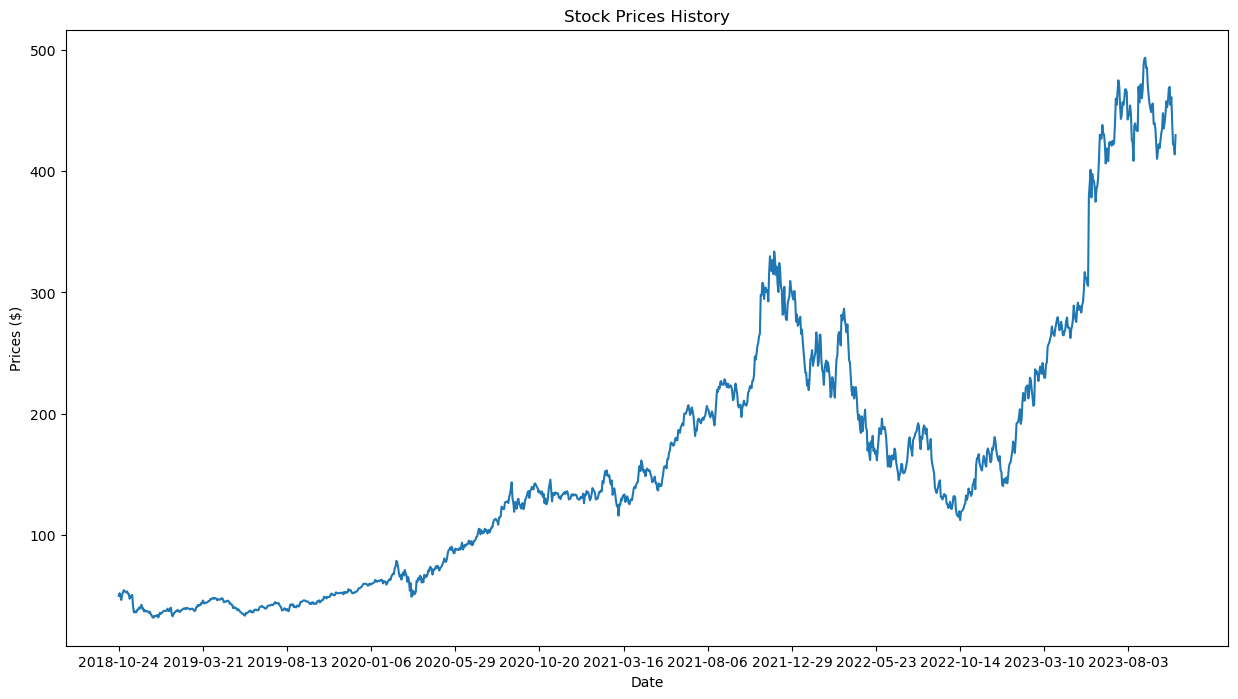

In [3]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df.loc[:, 'Date'], df.loc[: , 'Close'])
plt.xticks(np.arange(0,1230,100))
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [ ]:
# Converting the 'Date' from object time to the datetime format
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date', inplace=False)
print(df.head())

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2018-10-24  54.877499  55.347500  49.712502  49.852501  49.420170  88428800
2018-10-25  48.867500  52.437500  48.419998  51.959999  51.509392  95172000
2018-10-26  49.577499  51.209999  48.279999  49.572498  49.142597  66478400
2018-10-29  50.997501  51.032501  44.002499  46.404999  46.002567  75801600
2018-10-30  46.637501  50.849998  46.404999  50.750000  50.309891  80719200


We will use the Augmented Dickey-Fuller Test to determine if the data is stationary. 
<p> Null Hypothesis: Data is not stationary
<p> Alternative Hypothesis: Data is stationary
<p> We will only reject the null hypothesis if the p-value <= significance level of 0.05

In [44]:
# Augemented Dickey-Fuller Test
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df['Close'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -0.047194
p-value                           0.954451
#Lags Used                       11.000000
Number of Observations Used    1245.000000
Critical Value (1%)              -3.435613
Critical Value (5%)              -2.863864
Critical Value (10%)             -2.568007
dtype: float64


As we can see, the p-value is 0.954451, meaning that the dtaa is likely not stationary. So we will use the ARIMA model which takes into account of the trend.

In [75]:
# Split data into training and test sets, training size 80%
train_set, test_set = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]

Use Auto ARIMA to find the suitable p, d, q values for the ARIMA model

Performing stepwise search to minimize aic
 ARIMA(1,1,10)(0,0,0)[0] intercept   : AIC=6120.419, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6116.153, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6115.851, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6115.715, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6114.354, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6117.379, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.804 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1005
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3056.177
Date:                Tue, 24 Oct 2023   AIC                           6114.354
Time:                        23:28:38   BIC                           6119.266
Sample:                             0   HQIC                          6116.220
         

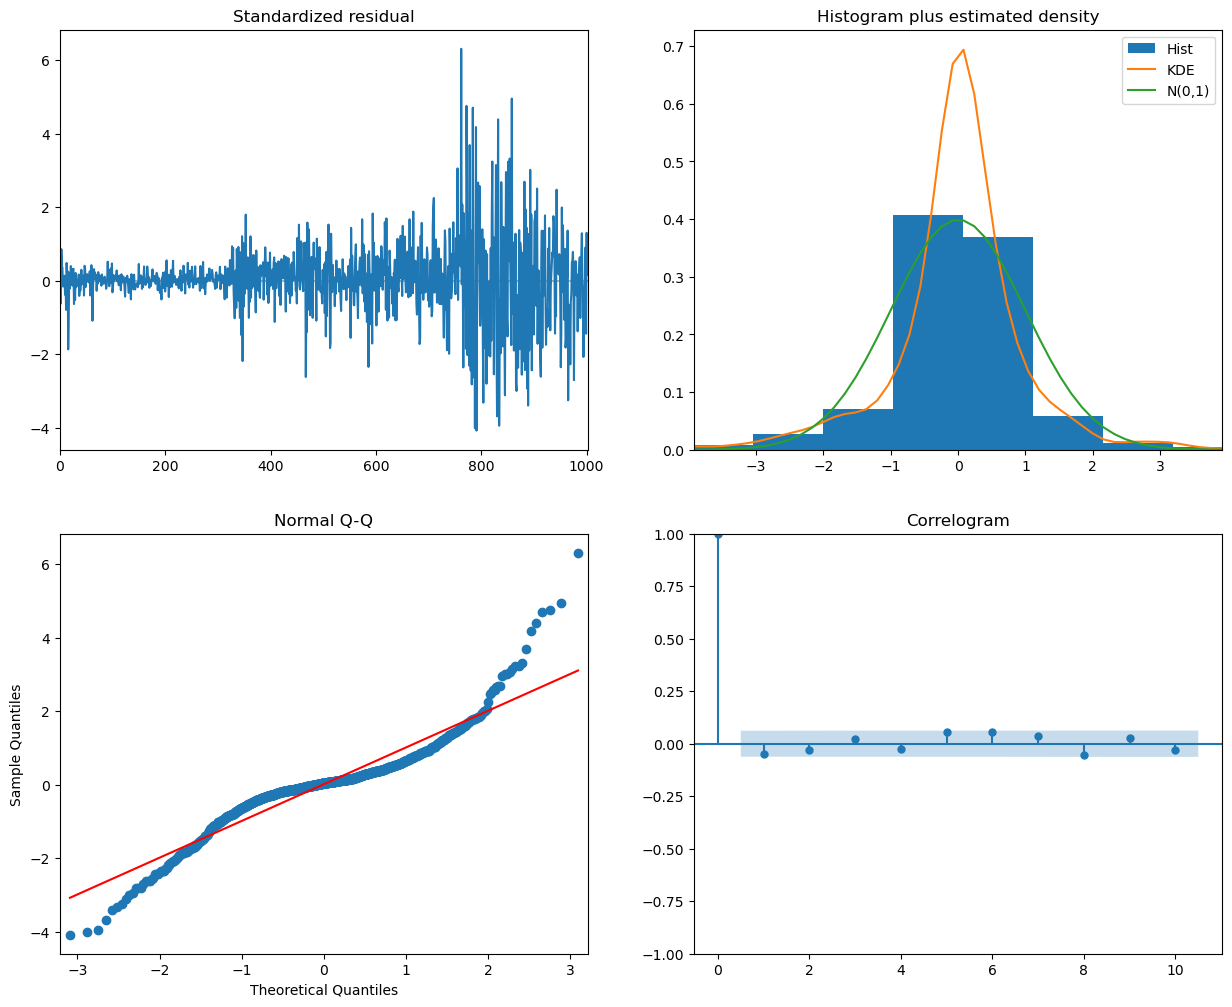

In [87]:
# ARIMA Model
ARIMA_model = pm.auto_arima(train_set['Close'], 
                      start_p=1, 
                      start_q=10,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=15, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      start_P=0,
                      D=0,
                      trace=True, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

print(ARIMA_model.summary())
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

c:\Users\HCM\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HCM\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


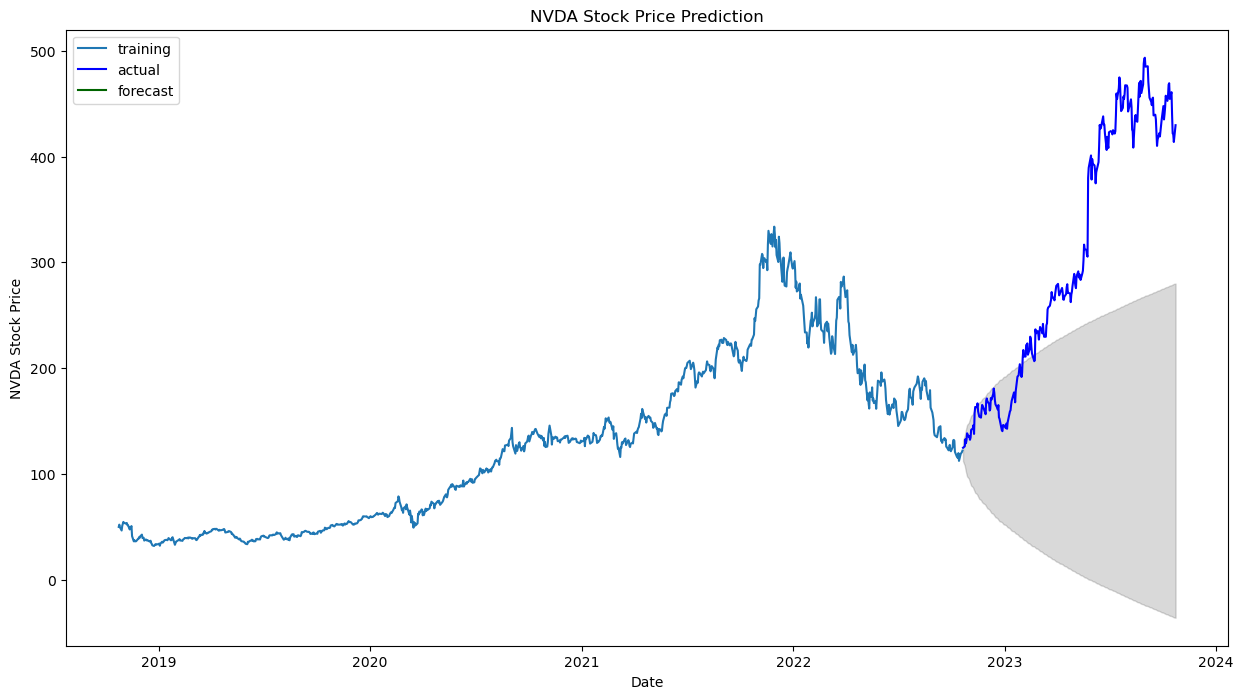

In [89]:
fitted, confint = ARIMA_model.predict(n_periods=len(test_set), return_conf_int=True)

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=test_set.index)
lower_series = pd.Series(confint[:, 0], index=test_set.index)
upper_series = pd.Series(confint[:, 1], index=test_set.index)

#plot
plt.figure(figsize=(15,8))
plt.plot(train_set['Close'], label='training')
plt.plot(test_set['Close'], color='blue', label='actual')
plt.plot(fitted_series, color='darkgreen', label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()

We will try to fit the model to the entire dataset and predict the stock prices for the next 12 days

Performing stepwise search to minimize aic
 ARIMA(1,1,10)(0,0,0)[0] intercept   : AIC=8199.338, Time=1.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8192.950, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8194.555, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8194.538, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8193.839, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8195.927, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.785 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1257
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4094.475
Date:                Tue, 24 Oct 2023   AIC                           8192.950
Time:                        23:52:16   BIC                           8203.221
Sample:                             0   HQIC                          8196.810
         

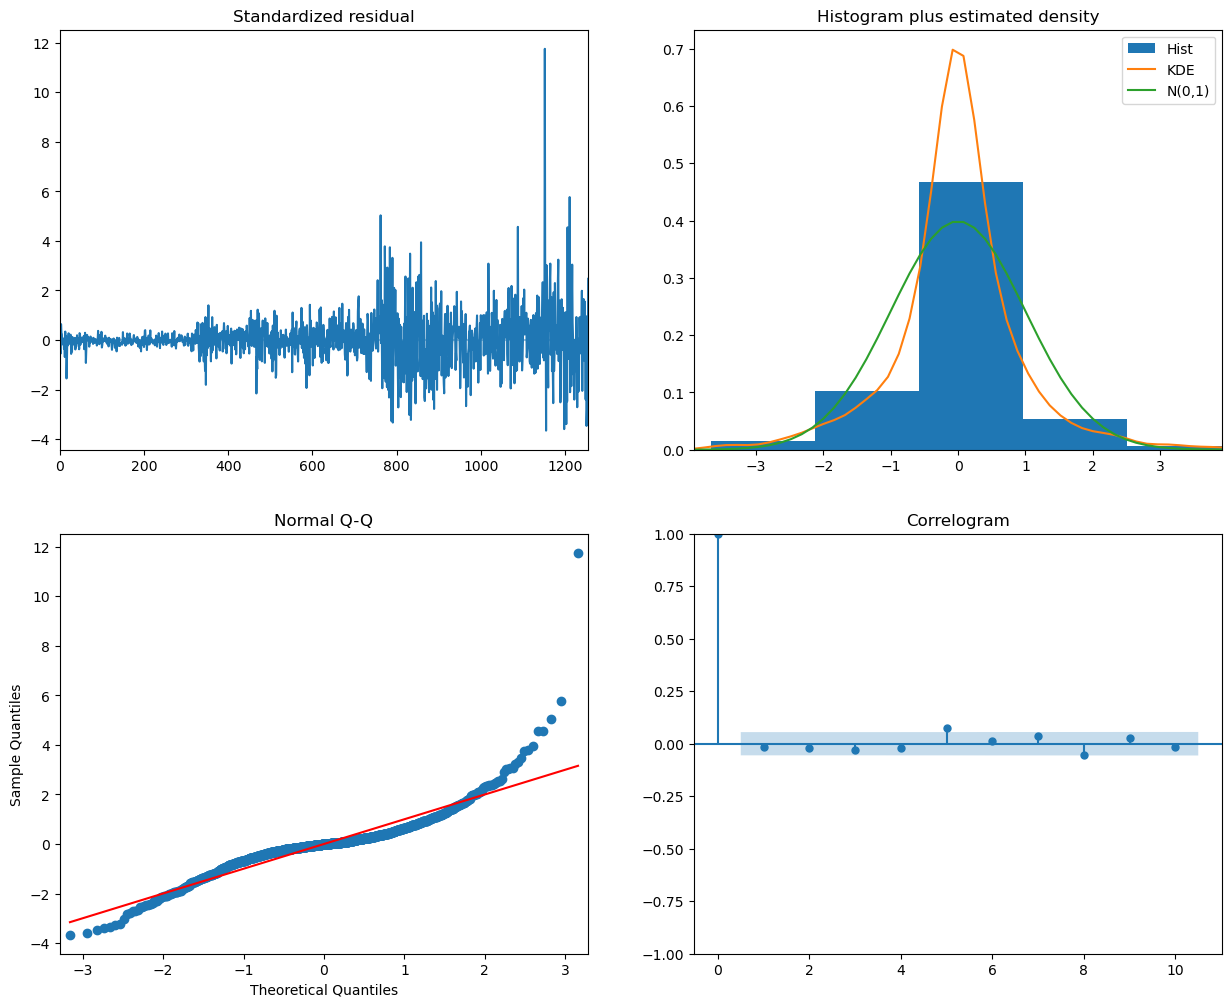

In [90]:
ARIMA_model = pm.auto_arima(df['Close'], 
                      start_p=1, 
                      start_q=10,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=15, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      start_P=0,
                      D=0,
                      trace=True, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)


In [93]:
forecast = ARIMA_model.predict(n_periods=12)

# make series for plotting purpose
forecast_series = pd.DataFrame(forecast, index=df[-12:].index, columns=['Close'])
print(forecast_series)

            Close
Date             
2023-10-06    NaN
2023-10-09    NaN
2023-10-10    NaN
2023-10-11    NaN
2023-10-12    NaN
2023-10-13    NaN
2023-10-16    NaN
2023-10-17    NaN
2023-10-18    NaN
2023-10-19    NaN
2023-10-20    NaN
2023-10-23    NaN


c:\Users\HCM\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HCM\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
